General imports

In [31]:
# Used imports -- standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cbsodata
import time
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# miscelaneous imports
import gc


Read csv files

In [32]:
# Read healthylife data
df_healthylife = pd.read_csv('healthylife_prep.csv', sep=',')

# Keep only the year in the datum for later merging
df_healthylife['Datum'] = pd.DatetimeIndex(df_healthylife['Datum']).year

# Replace values since some of the cbs only has data till 2021
df_healthylife["Datum"] = df_healthylife["Datum"].replace(2022, 2021)
df_healthylife["Datum"] = df_healthylife["Datum"].replace(2023, 2021)

# Display the DataFrame
df_healthylife


,Datum,verschil_Lengte,verschil_Gewicht,verschil_6 MWT,verschil_TUG,verschil_BMI,verschil_Conditie,verschil_Lenigheid,verschil_Knijpkracht,verschil_meting,Geslacht,age,Gemeente
0,2018,0.0,-2.30,-52.0,2.94,-0.906068,-0.125200,NaN,30.8,1.0,V,51,Sittard-Geleen
1,2019,NaN,-1.55,-20.0,-0.16,NaN,-0.013652,1.125,-2.5,2.0,V,45,Sittard-Geleen
2,2018,0.0,-7.20,-104.0,-2.43,-3.133140,-0.384503,-4.000,11.5,1.0,V,68,Sittard-Geleen
3,2018,1.0,-4.90,63.0,-1.92,-2.143719,0.080729,7.500,2.7,1.0,M,64,Sittard-Geleen
4,2018,0.0,-1.30,23.0,-2.07,-0.521359,0.020537,4.250,-1.7,1.0,V,63,Sittard-Geleen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2021,0.0,-0.20,42.0,-0.40,-0.059721,0.062730,-4.500,4.5,1.0,M,59,Onderbanken
1253,2021,0.0,-9.90,5.0,0.40,-3.160011,-0.018652,1.500,5.3,1.0,V,43,Onderbanken
1254,2021,0.0,-2.40,64.0,1.00,-0.732578,0.086585,0.000,-1.6,1.0,M,63,Onderbanken
1255,2021,0.0,0.00,25.0,-0.50,0.000000,0.048470,1.750,1.5,1.0,V,64,Onderbanken


In [33]:
# Read cbs data
df_cbs = pd.read_csv('cbsdata_prep.csv', sep=',')

# Display the DataFrame
df_cbs

,Gemeente,AantalInwoners,Mannen,Vrouwen,kTot15Jaar,kTot25Jaar,kTot45Jaar,kTot65Jaar,kJaarOfOuder,Ongehuwd,...,ErnstigOvergewichtObesitas,VoldoetAanBeweegrichtlijn,WekelijksSporter,Mantelzorger,ZwaarBelasteMantelzorgers,UrenMantelzorgPerWeek,Rokers,VoldoetAanRichtlijnAlcoholgebruik,ZwareDrinker,OvermatigDrinker
0,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
1,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
2,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
3,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
4,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5419,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5420,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5421,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5422,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7


Merging dataframes

In [34]:
# Merge the df's on the columns gemeente and datum
df_healthylife_cbs = pd.merge(df_healthylife, df_cbs, left_on=['Gemeente', 'Datum'], right_on=['Gemeente', 'Perioden'], how='inner')

# Drop columns
df_healthylife_cbs.drop(columns=['Perioden'], inplace=True)

In [35]:
df_healthylife_cbs

,Datum,verschil_Lengte,verschil_Gewicht,verschil_6 MWT,verschil_TUG,verschil_BMI,verschil_Conditie,verschil_Lenigheid,verschil_Knijpkracht,verschil_meting,...,ErnstigOvergewichtObesitas,VoldoetAanBeweegrichtlijn,WekelijksSporter,Mantelzorger,ZwaarBelasteMantelzorgers,UrenMantelzorgPerWeek,Rokers,VoldoetAanRichtlijnAlcoholgebruik,ZwareDrinker,OvermatigDrinker
0,2018,0.0,-2.3,-52.0,2.94,-0.906068,-0.125200,NaN,30.8,1.0,...,17.7,45.9,46.0,16.7,12.6,10.4,18.3,47.3,6.5,5.3
1,2018,0.0,-7.2,-104.0,-2.43,-3.133140,-0.384503,-4.00,11.5,1.0,...,17.7,45.9,46.0,16.7,12.6,10.4,18.3,47.3,6.5,5.3
2,2018,1.0,-4.9,63.0,-1.92,-2.143719,0.080729,7.50,2.7,1.0,...,17.7,45.9,46.0,16.7,12.6,10.4,18.3,47.3,6.5,5.3
3,2018,0.0,-1.3,23.0,-2.07,-0.521359,0.020537,4.25,-1.7,1.0,...,17.7,45.9,46.0,16.7,12.6,10.4,18.3,47.3,6.5,5.3
4,2018,0.0,2.0,126.0,0.69,0.800000,0.221264,-2.50,5.5,1.0,...,17.7,45.9,46.0,16.7,12.6,10.4,18.3,47.3,6.5,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2021,-0.5,0.4,55.0,-5.00,0.405677,0.114746,-0.50,6.4,1.0,...,22.9,36.2,35.6,15.5,19.7,14.4,24.0,49.7,5.9,4.8
1253,2021,0.0,-2.8,121.0,-2.00,-1.093750,0.180107,2.00,0.3,1.0,...,22.9,36.2,35.6,15.5,19.7,14.4,24.0,49.7,5.9,4.8
1254,2021,-0.2,0.0,109.0,-1.00,0.103527,0.170950,2.25,3.7,1.0,...,22.9,36.2,35.6,15.5,19.7,14.4,24.0,49.7,5.9,4.8
1255,2021,0.5,-1.3,175.0,-4.00,-0.695913,0.315029,1.00,2.4,1.0,...,22.9,36.2,35.6,15.5,19.7,14.4,24.0,49.7,5.9,4.8


Get insights into NaN values

In [36]:
# Print NaN counts for each column
nan_counts = df_healthylife_cbs.isna().sum()
print(nan_counts)

Datum                                 0
verschil_Lengte                      37
verschil_Gewicht                     10
verschil_6 MWT                       51
verschil_TUG                         34
                                     ..
UrenMantelzorgPerWeek                 0
Rokers                                0
VoldoetAanRichtlijnAlcoholgebruik     0
ZwareDrinker                          0
OvermatigDrinker                      0
Length: 262, dtype: int64


<Axes: >

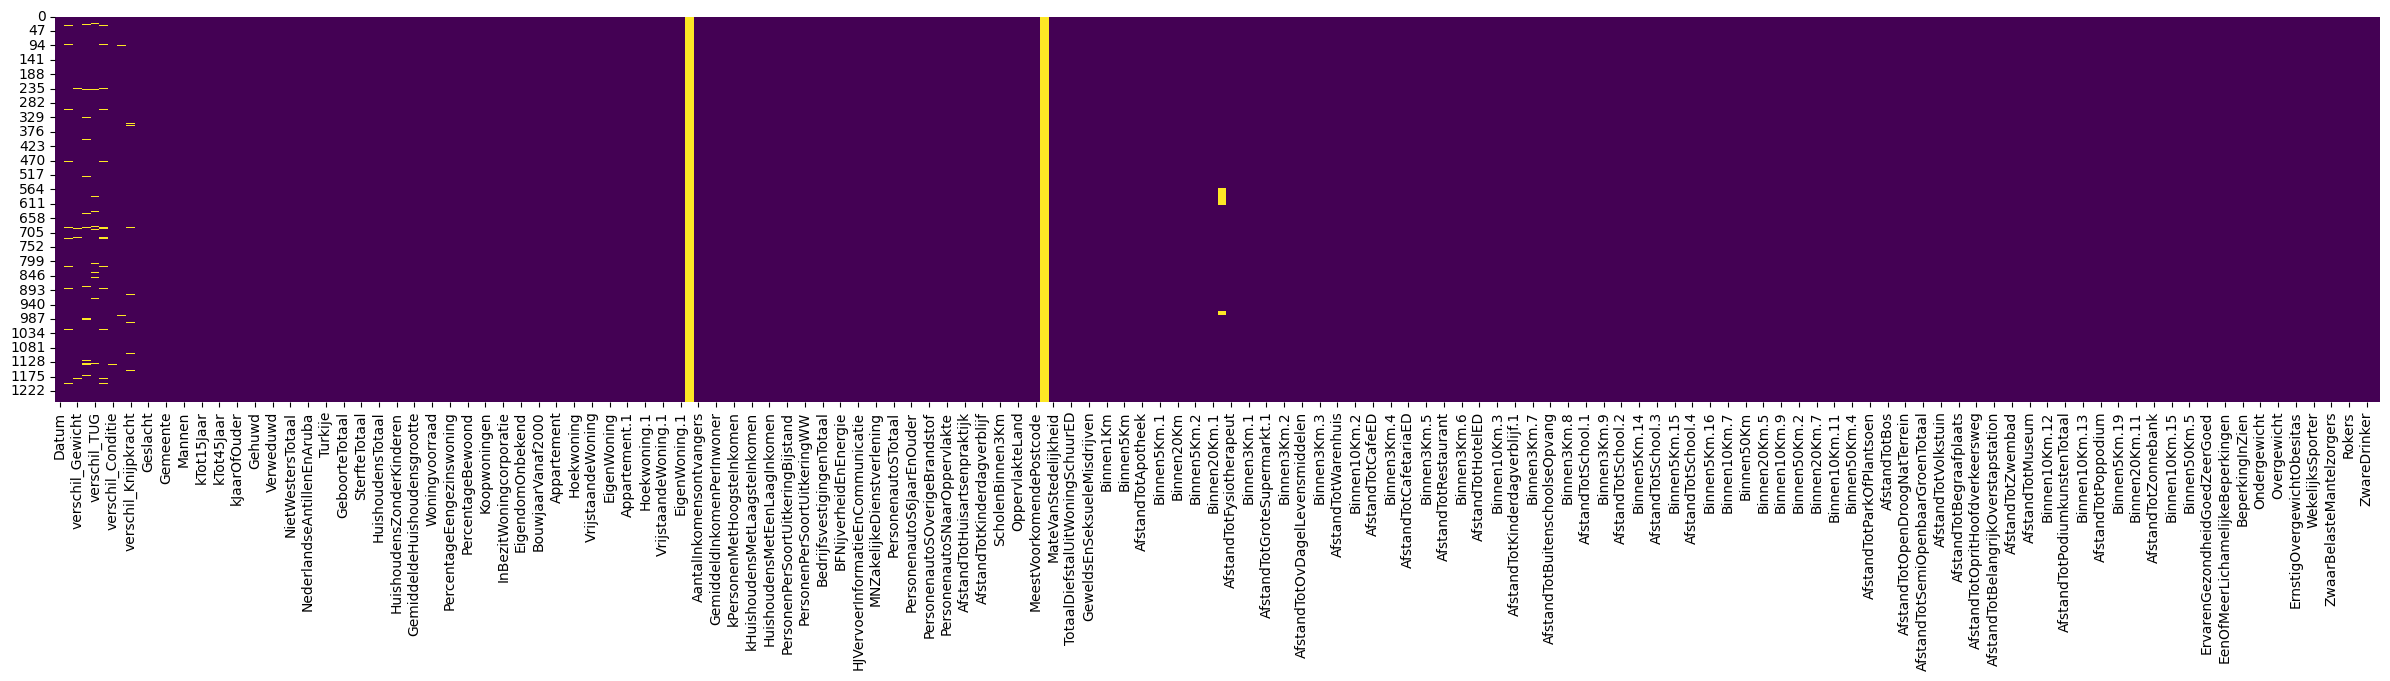

In [37]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_healthylife_cbs.isnull(),cbar=False,cmap='viridis')

In [38]:
# Get all columns with only NaN values
nan_columns = df_healthylife_cbs.columns[df_healthylife_cbs.isna().all()].tolist()
print(nan_columns)

# Remove all columns with only NaN values
df_healthylife_cbs.drop(columns=nan_columns, inplace=True)

['PercentageWoningenMetStadsverwarming', 'Dekkingspercentage']


<Axes: >

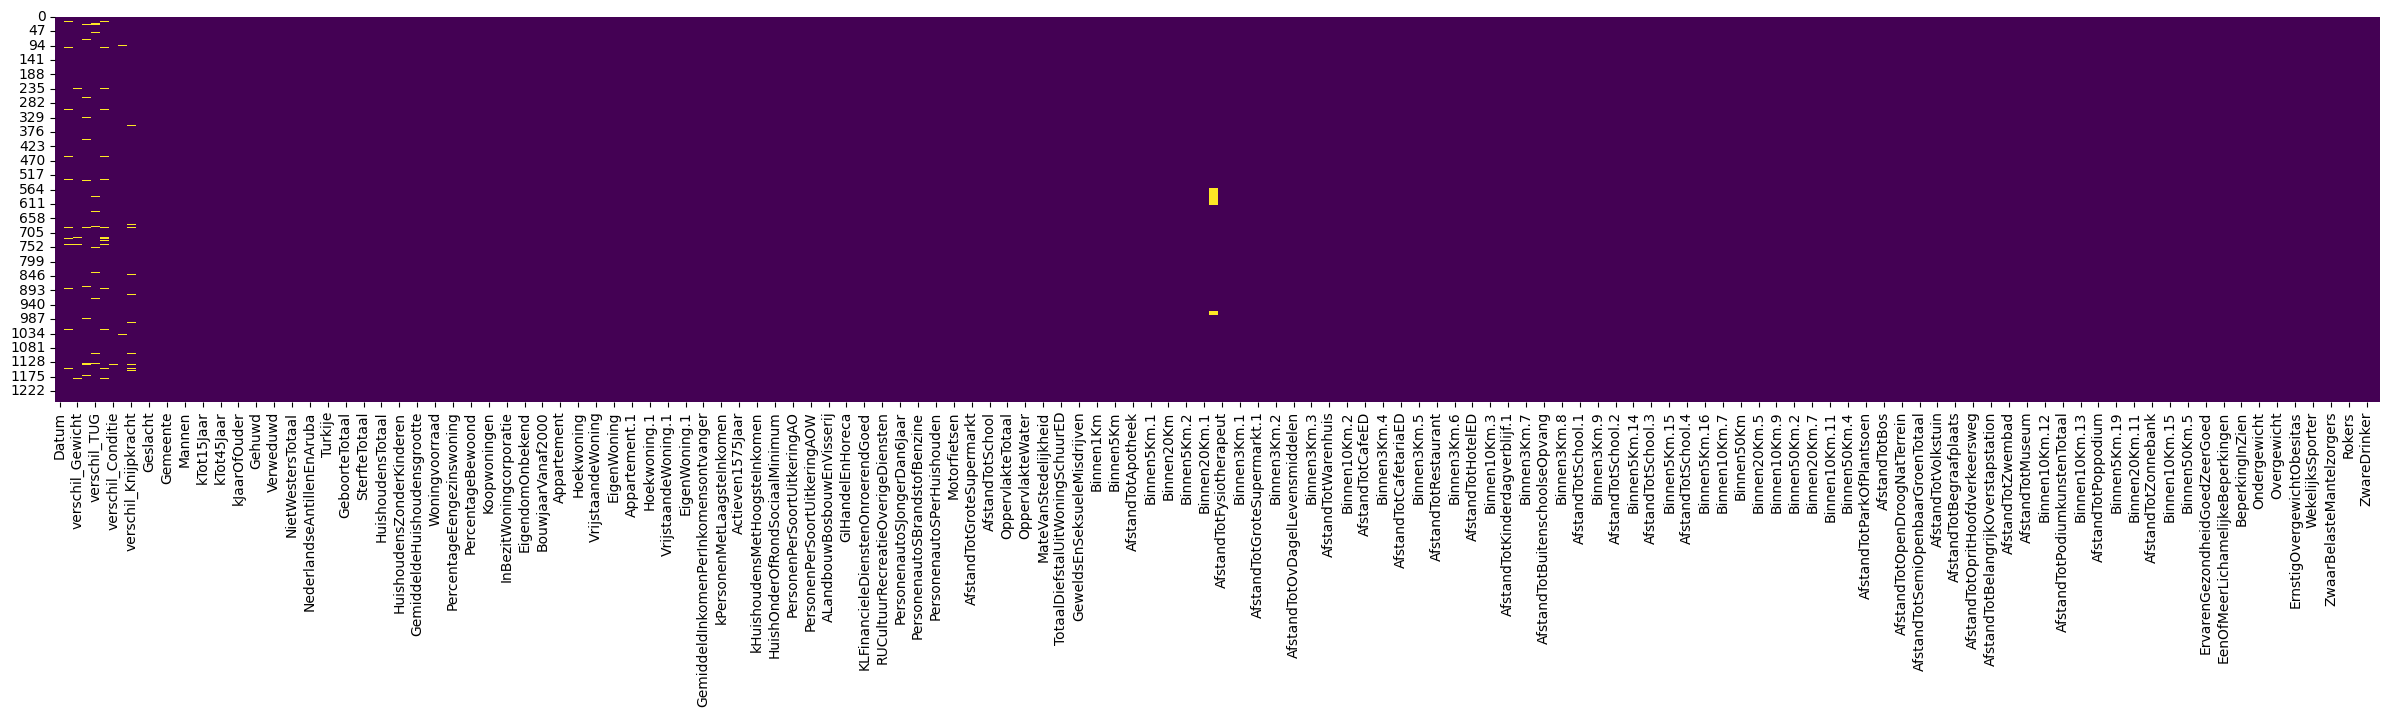

In [39]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_healthylife_cbs.isnull(),cbar=False,cmap='viridis')

In [40]:
# Find column names with NaN values
columns_with_nan = df_healthylife_cbs.columns[df_healthylife_cbs.isna().any()].tolist()

# Print column names with NaN values
for column in columns_with_nan:
    print(column)

verschil_Lengte
verschil_Gewicht
verschil_6 MWT
verschil_TUG
verschil_BMI
verschil_Conditie
verschil_Lenigheid
verschil_Knijpkracht
AfstandTotConsultatiebureau


In [41]:
# Remove non important column with only NaN values
df_healthylife_cbs.drop(columns='AfstandTotConsultatiebureau', inplace=True)

<Axes: >

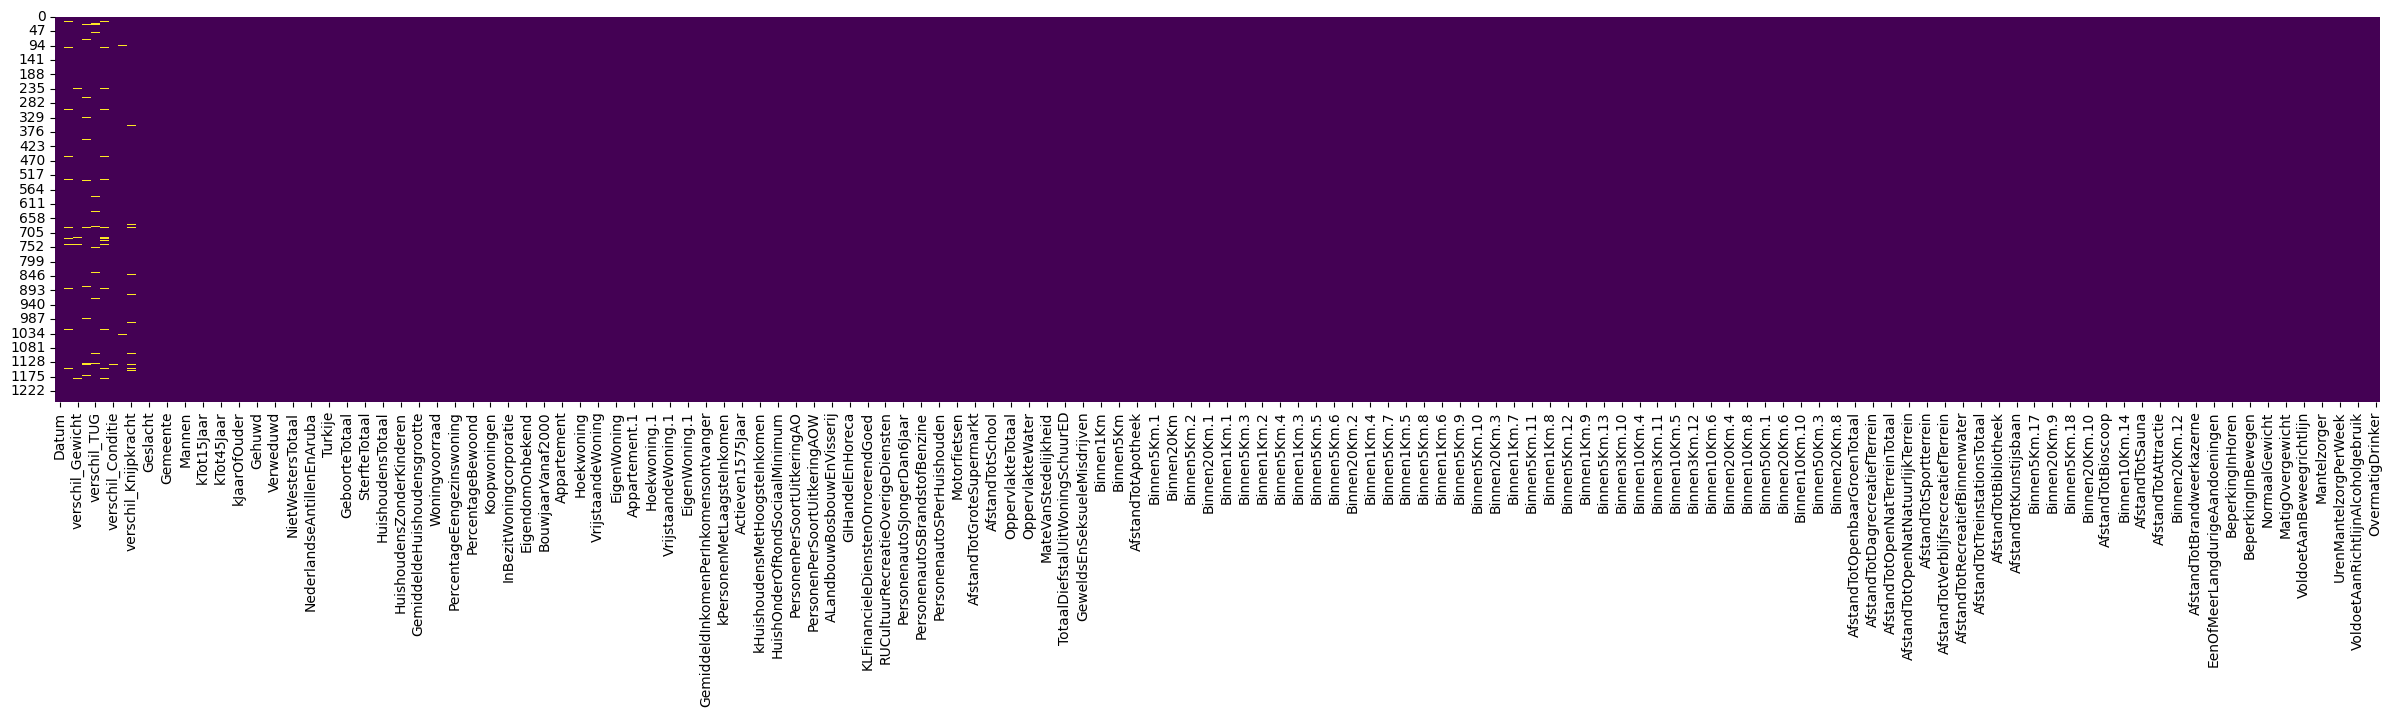

In [42]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_healthylife_cbs.isnull(),cbar=False,cmap='viridis')

<Axes: >

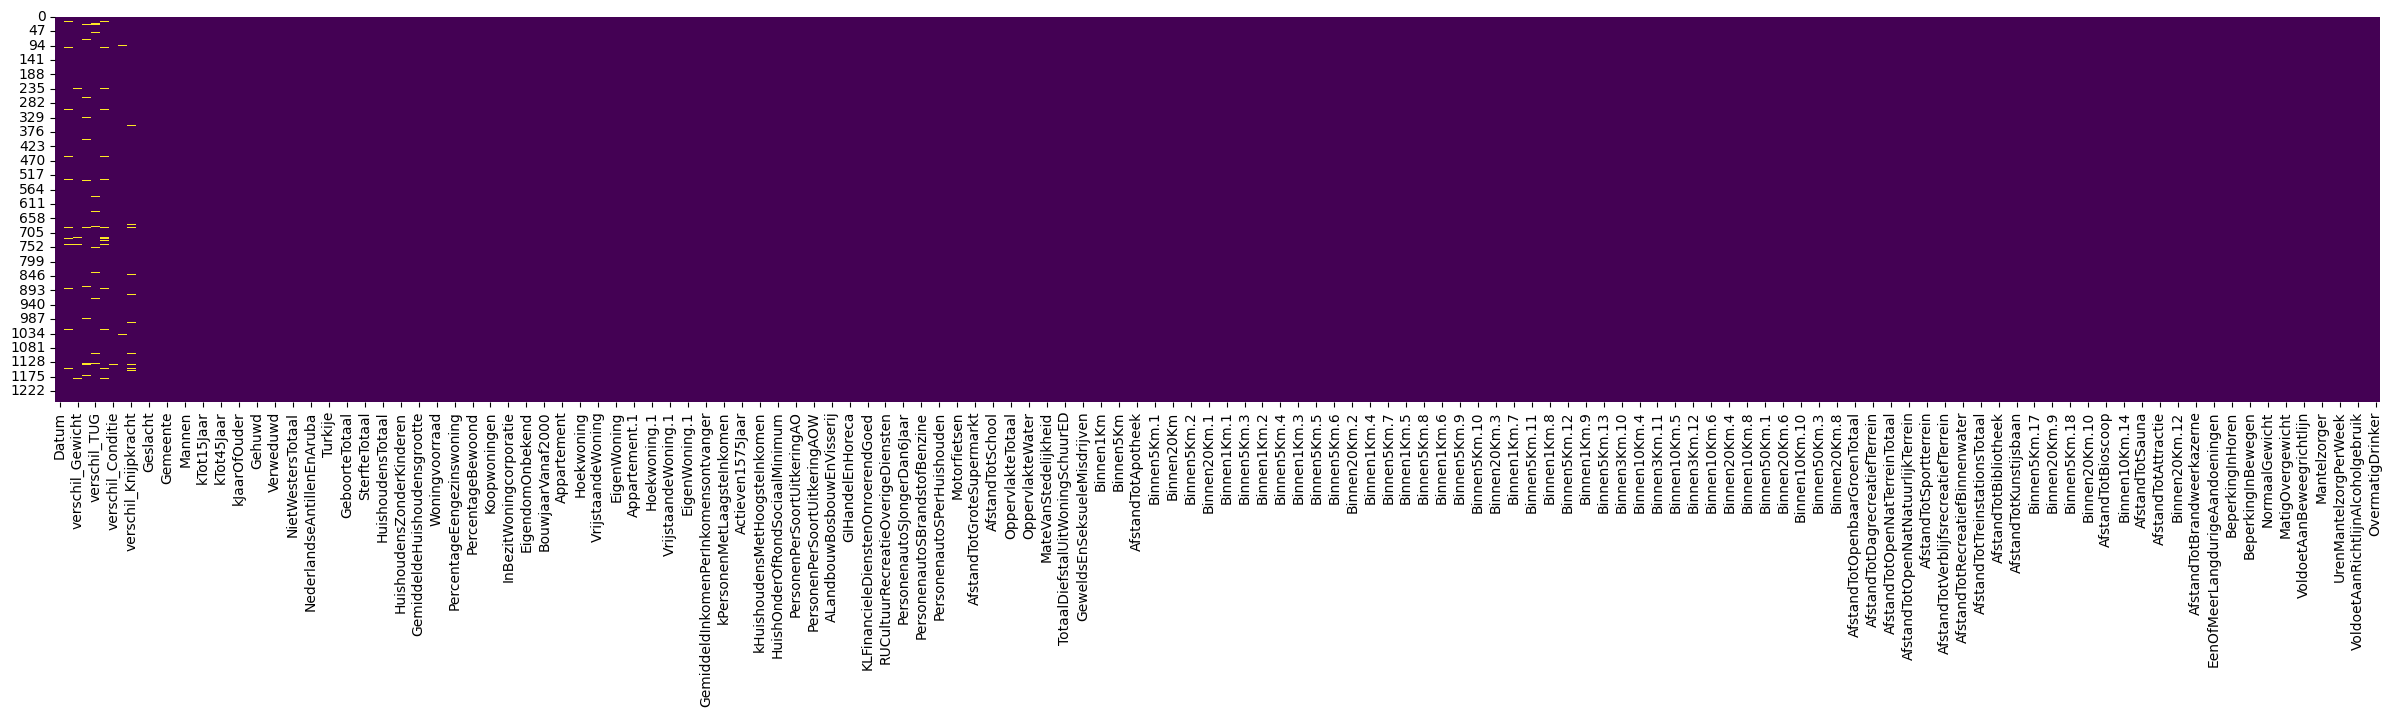

In [43]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_healthylife_cbs.isnull(),cbar=False,cmap='viridis')

Generate dummies

In [44]:
# Drop columns what should not be used as predictor
df_healthylife_cbs.drop(columns=['Gemeente', 'Datum'], inplace=True)

In [45]:
# Get dummies
df_healthylife_cbs = pd.get_dummies(df_healthylife_cbs, drop_first=True, dtype=int)

Reduce Columns

In [46]:
# Defining the function that you will run later
#https://github.com/K-Ellis/Neural-Network-Classification-and-Unbalanced-Bank-Marketing-Data/issues/1#issue-234132765
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print(variables)
    
    return X[[i for i in variables]]

def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores

In [47]:
# Vif scores on all columns
vif_scores(df_healthylife_cbs.drop(columns=['verschil_Lengte', 'verschil_Gewicht',
               'verschil_6 MWT', 'verschil_TUG',
               'verschil_BMI', 'verschil_Conditie',
               'verschil_Lenigheid', 'verschil_Knijpkracht']))

,Independent Features,VIF Scores
0,verschil_meting,1.065126
1,age,1.107196
2,AantalInwoners,78774.357945
3,Mannen,10714.122830
4,Vrouwen,16567.259696
...,...,...
243,Rokers,1301.653561
244,VoldoetAanRichtlijnAlcoholgebruik,358.702300
245,ZwareDrinker,1053.153757
246,OvermatigDrinker,3661.391187


In [48]:
#remaining columns with vif score lower then 5
ListMulticollinearityVIFTestColumns = []
vif_scores(calculate_vif_(df_healthylife_cbs.drop(columns=['verschil_Lengte', 'verschil_Gewicht',
               'verschil_6 MWT', 'verschil_TUG',
               'verschil_BMI', 'verschil_Conditie',
               'verschil_Lenigheid', 'verschil_Knijpkracht']),5))

248


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:   11.0s finished


Fri Jun 23 13:11:04 2023 dropping 'Binnen1Km.3' at index: 126
247


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    6.5s finished


Fri Jun 23 13:11:11 2023 dropping 'AfstandTotBrandweerkazerne' at index: 225
246


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 246 out of 246 | elapsed:    6.4s finished


Fri Jun 23 13:11:18 2023 dropping 'ALandbouwBosbouwEnVisserij' at index: 75
245


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    6.7s finished


Fri Jun 23 13:11:25 2023 dropping 'kTot25Jaar' at index: 6
244


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 244 out of 244 | elapsed:    6.1s finished


Fri Jun 23 13:11:31 2023 dropping 'AfstandTotSauna' at index: 217
243


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 220 out of 243 | elapsed:    5.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    6.0s finished


Fri Jun 23 13:11:37 2023 dropping 'AfstandTotSchool.2' at index: 158
242


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    5.9s finished


Fri Jun 23 13:11:44 2023 dropping 'PersonenPerSoortUitkeringAOW' at index: 72
241


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 218 out of 241 | elapsed:    5.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    6.1s finished


Fri Jun 23 13:11:50 2023 dropping 'AfstandTotPodiumkunstenTotaal' at index: 206
240


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.8s finished


Fri Jun 23 13:11:56 2023 dropping 'Binnen5Km.6' at index: 126
239


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 216 out of 239 | elapsed:    5.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    5.9s finished


Fri Jun 23 13:12:02 2023 dropping 'AfstandTotAttractie' at index: 214
238


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 215 out of 238 | elapsed:    5.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 238 out of 238 | elapsed:    5.6s finished


Fri Jun 23 13:12:08 2023 dropping 'AfstandTotKunstijsbaan' at index: 200
237


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:    5.6s finished


Fri Jun 23 13:12:14 2023 dropping 'Binnen1Km.4' at index: 129
236


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:    6.2s finished


Fri Jun 23 13:12:21 2023 dropping 'OppervlakteWater' at index: 94
235


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:    6.4s finished


Fri Jun 23 13:12:28 2023 dropping 'Binnen50Km.2' at index: 173
234


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    5.7s finished


Fri Jun 23 13:12:34 2023 dropping 'AfstandTotVolkstuin' at index: 188
233


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 233 | elapsed:    5.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    5.4s finished


Fri Jun 23 13:12:39 2023 dropping 'AfstandTotParkOfPlantsoen' at index: 180
232


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 209 out of 232 | elapsed:    5.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    5.5s finished


Fri Jun 23 13:12:45 2023 dropping 'Binnen3Km.6' at index: 136
231


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 208 out of 231 | elapsed:    4.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    5.2s finished


Fri Jun 23 13:12:51 2023 dropping 'AfstandTotOpenDroogNatTerrein' at index: 182
230


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 207 out of 230 | elapsed:    4.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    4.6s finished


Fri Jun 23 13:12:56 2023 dropping 'Binnen20Km.5' at index: 168
229


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 206 out of 229 | elapsed:    4.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 229 out of 229 | elapsed:    5.2s finished


Fri Jun 23 13:13:01 2023 dropping 'Binnen5Km.15' at index: 158
228


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    4.6s finished


Fri Jun 23 13:13:06 2023 dropping 'Binnen20Km.1' at index: 112
227


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    4.5s finished


Fri Jun 23 13:13:11 2023 dropping 'GeboorteTotaal' at index: 20
226


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:    4.3s finished


Fri Jun 23 13:13:15 2023 dropping 'Vrouwen' at index: 4
225


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    4.6s finished


Fri Jun 23 13:13:20 2023 dropping 'kTot15Jaar' at index: 4
224


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    5.1s finished


Fri Jun 23 13:13:26 2023 dropping 'kTot65Jaar' at index: 5
223


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 223 | elapsed:    4.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 223 out of 223 | elapsed:    5.1s finished


Fri Jun 23 13:13:31 2023 dropping 'Mannen' at index: 3
222


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    4.9s finished


Fri Jun 23 13:13:36 2023 dropping 'kTot45Jaar' at index: 3
221


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 198 out of 221 | elapsed:    4.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 221 out of 221 | elapsed:    5.2s finished


Fri Jun 23 13:13:42 2023 dropping 'kJaarOfOuder' at index: 3
220


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.4s finished


Fri Jun 23 13:13:48 2023 dropping 'AantalInwoners' at index: 2
219


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 out of 219 | elapsed:    5.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 219 out of 219 | elapsed:    5.5s finished


Fri Jun 23 13:13:53 2023 dropping 'Gehuwd' at index: 3
218


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 218 out of 218 | elapsed:    5.0s finished


Fri Jun 23 13:13:59 2023 dropping 'NederlandseAntillenEnAruba' at index: 8
217


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 194 out of 217 | elapsed:    4.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    4.9s finished


Fri Jun 23 13:14:04 2023 dropping 'Ongehuwd' at index: 2
216


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    5.2s finished


Fri Jun 23 13:14:09 2023 dropping 'Verweduwd' at index: 3
215


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    5.1s finished


Fri Jun 23 13:14:15 2023 dropping 'Gescheiden' at index: 2
214


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    4.6s finished


Fri Jun 23 13:14:20 2023 dropping 'Marokko' at index: 4
213


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    5.3s finished


Fri Jun 23 13:14:25 2023 dropping 'WestersTotaal' at index: 2
212


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    4.8s finished


Fri Jun 23 13:14:30 2023 dropping 'Suriname' at index: 3
211


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 188 out of 211 | elapsed:    4.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    4.6s finished


Fri Jun 23 13:14:35 2023 dropping 'GeboorteRelatief' at index: 5
210


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 187 out of 210 | elapsed:    4.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    4.5s finished


Fri Jun 23 13:14:40 2023 dropping 'SterfteTotaal' at index: 5
209


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 209 out of 209 | elapsed:    4.4s finished


Fri Jun 23 13:14:45 2023 dropping 'Turkije' at index: 3
208


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 185 out of 208 | elapsed:    4.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    4.4s finished


Fri Jun 23 13:14:50 2023 dropping 'SterfteRelatief' at index: 4
207


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 out of 207 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    4.2s finished


Fri Jun 23 13:14:54 2023 dropping 'NietWestersTotaal' at index: 2
206


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 206 out of 206 | elapsed:    4.2s finished


Fri Jun 23 13:14:59 2023 dropping 'OverigNietWesters' at index: 2
205


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    4.2s finished


Fri Jun 23 13:15:03 2023 dropping 'HuishoudensTotaal' at index: 2
204


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    4.1s finished


Fri Jun 23 13:15:08 2023 dropping 'Eenpersoonshuishoudens' at index: 2
203


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 180 out of 203 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    4.1s finished


Fri Jun 23 13:15:12 2023 dropping 'HuishoudensZonderKinderen' at index: 2
202


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:    4.3s finished


Fri Jun 23 13:15:17 2023 dropping 'HuishoudensMetKinderen' at index: 2
201


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 178 out of 201 | elapsed:    4.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    4.9s finished


Fri Jun 23 13:15:22 2023 dropping 'GemiddeldeHuishoudensgrootte' at index: 2
200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished


Fri Jun 23 13:15:26 2023 dropping 'Bevolkingsdichtheid' at index: 2
199


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 176 out of 199 | elapsed:    4.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    4.5s finished


Fri Jun 23 13:15:31 2023 dropping 'Woningvoorraad' at index: 2
198


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    4.7s finished


Fri Jun 23 13:15:36 2023 dropping 'GemiddeldeWoningwaarde' at index: 2
197


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 174 out of 197 | elapsed:    4.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    4.5s finished


Fri Jun 23 13:15:41 2023 dropping 'PercentageEengezinswoning' at index: 2
196


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    5.2s finished


Fri Jun 23 13:15:47 2023 dropping 'PercentageMeergezinswoning' at index: 2
195


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 172 out of 195 | elapsed:    4.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    4.4s finished


Fri Jun 23 13:15:51 2023 dropping 'PercentageBewoond' at index: 2
194


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    4.1s finished


Fri Jun 23 13:15:56 2023 dropping 'PercentageOnbewoond' at index: 2
193


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 170 out of 193 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    3.7s finished


Fri Jun 23 13:16:00 2023 dropping 'Koopwoningen' at index: 2
192


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    3.7s finished


Fri Jun 23 13:16:04 2023 dropping 'HuurwoningenTotaal' at index: 2
191


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 168 out of 191 | elapsed:    3.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    3.4s finished


Fri Jun 23 13:16:07 2023 dropping 'InBezitWoningcorporatie' at index: 2
190


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:16:11 2023 dropping 'InBezitOverigeVerhuurders' at index: 2
189


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 166 out of 189 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    3.3s finished


Fri Jun 23 13:16:15 2023 dropping 'EigendomOnbekend' at index: 2
188


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 165 out of 188 | elapsed:    3.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 188 out of 188 | elapsed:    3.4s finished


Fri Jun 23 13:16:18 2023 dropping 'BouwjaarVoor2000' at index: 2
187


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 164 out of 187 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:    3.1s finished


Fri Jun 23 13:16:22 2023 dropping 'BouwjaarVanaf2000' at index: 2
186


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:    3.1s finished


Fri Jun 23 13:16:25 2023 dropping 'GemiddeldElektriciteitsverbruikTotaal' at index: 2
185


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:    3.2s finished


Fri Jun 23 13:16:29 2023 dropping 'Appartement' at index: 2
184


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.9s finished


Fri Jun 23 13:16:32 2023 dropping 'Tussenwoning' at index: 2
183


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 out of 183 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    3.0s finished


Fri Jun 23 13:16:35 2023 dropping 'Hoekwoning' at index: 2
182


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    3.1s finished


Fri Jun 23 13:16:38 2023 dropping 'TweeOnderEenKapWoning' at index: 2
181


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 158 out of 181 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    3.1s finished


Fri Jun 23 13:16:42 2023 dropping 'VrijstaandeWoning' at index: 2
180


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 157 out of 180 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.6s finished


Fri Jun 23 13:16:46 2023 dropping 'Huurwoning' at index: 2
179


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 156 out of 179 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    4.0s finished


Fri Jun 23 13:16:50 2023 dropping 'PersonenautoSTotaal' at index: 31
178


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    3.4s finished


Fri Jun 23 13:16:54 2023 dropping 'EigenWoning' at index: 2
177


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.6s finished


Fri Jun 23 13:16:58 2023 dropping 'GemiddeldAardgasverbruikTotaal' at index: 2
176


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    4.2s finished


Fri Jun 23 13:17:02 2023 dropping 'Appartement.1' at index: 2
175


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 152 out of 175 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    3.5s finished


Fri Jun 23 13:17:06 2023 dropping 'Tussenwoning.1' at index: 2
174


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    4.0s finished


Fri Jun 23 13:17:10 2023 dropping 'Hoekwoning.1' at index: 2
173


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 173 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    3.9s finished


Fri Jun 23 13:17:14 2023 dropping 'TweeOnderEenKapWoning.1' at index: 2
172


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    3.8s finished


Fri Jun 23 13:17:19 2023 dropping 'VrijstaandeWoning.1' at index: 2
171


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 148 out of 171 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    3.5s finished


Fri Jun 23 13:17:22 2023 dropping 'Huurwoning.1' at index: 2
170


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    3.6s finished


Fri Jun 23 13:17:26 2023 dropping 'EigenWoning.1' at index: 2
169


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 out of 169 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    3.2s finished


Fri Jun 23 13:17:30 2023 dropping 'GemiddeldInkomenPerInkomensontvanger' at index: 3
168


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    3.0s finished


Fri Jun 23 13:17:33 2023 dropping 'GemiddeldInkomenPerInwoner' at index: 3
167


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 144 out of 167 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    3.2s finished


Fri Jun 23 13:17:37 2023 dropping 'kPersonenMetLaagsteInkomen' at index: 3
166


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 143 out of 166 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    3.7s finished


Fri Jun 23 13:17:41 2023 dropping 'kPersonenMetHoogsteInkomen' at index: 3
165


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 142 out of 165 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    2.8s finished


Fri Jun 23 13:17:44 2023 dropping 'Actieven1575Jaar' at index: 3
164


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 141 out of 164 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.2s finished


Fri Jun 23 13:17:47 2023 dropping 'kHuishoudensMetLaagsteInkomen' at index: 3
163


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 140 out of 163 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    2.7s finished


Fri Jun 23 13:17:50 2023 dropping 'kHuishoudensMetHoogsteInkomen' at index: 3
162


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.4s finished


Fri Jun 23 13:17:53 2023 dropping 'HuishoudensMetEenLaagInkomen' at index: 3
161


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 138 out of 161 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.7s finished


Fri Jun 23 13:17:56 2023 dropping 'HuishOnderOfRondSociaalMinimum' at index: 3
160


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.8s finished


Fri Jun 23 13:17:59 2023 dropping 'PersonenPerSoortUitkeringBijstand' at index: 3
159


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 136 out of 159 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    2.8s finished


Fri Jun 23 13:18:02 2023 dropping 'PersonenPerSoortUitkeringAO' at index: 3
158


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 135 out of 158 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:05 2023 dropping 'PersonenPerSoortUitkeringWW' at index: 3
157


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:    2.4s finished


Fri Jun 23 13:18:07 2023 dropping 'AantalInkomensontvangers' at index: 2
156


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    3.1s finished


Fri Jun 23 13:18:11 2023 dropping 'BedrijfsvestigingenTotaal' at index: 2
155


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 132 out of 155 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    3.2s finished


Fri Jun 23 13:18:14 2023 dropping 'BFNijverheidEnEnergie' at index: 2
154


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    3.5s finished


Fri Jun 23 13:18:18 2023 dropping 'GIHandelEnHoreca' at index: 2
153


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    2.7s finished


Fri Jun 23 13:18:21 2023 dropping 'HJVervoerInformatieEnCommunicatie' at index: 2
152


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:24 2023 dropping 'KLFinancieleDienstenOnroerendGoed' at index: 2
151


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 128 out of 151 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:27 2023 dropping 'MNZakelijkeDienstverlening' at index: 2
150


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:30 2023 dropping 'RUCultuurRecreatieOverigeDiensten' at index: 2
149


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 126 out of 149 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:    2.4s finished


Fri Jun 23 13:18:32 2023 dropping 'PersonenautoSJongerDan6Jaar' at index: 2
148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    3.1s finished


Fri Jun 23 13:18:36 2023 dropping 'PersonenautoS6JaarEnOuder' at index: 2
147


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    2.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:39 2023 dropping 'PersonenautoSBrandstofBenzine' at index: 2
146


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    3.1s finished


Fri Jun 23 13:18:42 2023 dropping 'PersonenautoSOverigeBrandstof' at index: 2
145


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 122 out of 145 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    3.1s finished


Fri Jun 23 13:18:46 2023 dropping 'PersonenautoSPerHuishouden' at index: 2
144


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:48 2023 dropping 'PersonenautoSNaarOppervlakte' at index: 2
143


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 120 out of 143 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:51 2023 dropping 'Motorfietsen' at index: 2
142


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 119 out of 142 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    2.3s finished


Fri Jun 23 13:18:53 2023 dropping 'AfstandTotHuisartsenpraktijk' at index: 2
141


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 118 out of 141 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:    1.9s finished


Fri Jun 23 13:18:56 2023 dropping 'AfstandTotGroteSupermarkt' at index: 2
140


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:18:58 2023 dropping 'AfstandTotKinderdagverblijf' at index: 2
139


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 139 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:00 2023 dropping 'AfstandTotSchool' at index: 2
138


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:02 2023 dropping 'ScholenBinnen3Km' at index: 2
137


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 114 out of 137 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    1.7s finished


Fri Jun 23 13:19:04 2023 dropping 'OppervlakteTotaal' at index: 2
136


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 113 out of 136 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished


Fri Jun 23 13:19:06 2023 dropping 'OppervlakteLand' at index: 2
135


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 out of 135 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.6s finished


Fri Jun 23 13:19:08 2023 dropping 'MateVanStedelijkheid' at index: 2
134


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:10 2023 dropping 'Omgevingsadressendichtheid' at index: 2
133


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    1.7s finished


Fri Jun 23 13:19:12 2023 dropping 'TotaalDiefstalUitWoningSchuurED' at index: 2
132


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 109 out of 132 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.6s finished


Fri Jun 23 13:19:14 2023 dropping 'VernielingMisdrijfTegenOpenbareOrde' at index: 2
131


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 108 out of 131 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:16 2023 dropping 'GeweldsEnSeksueleMisdrijven' at index: 2
130


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.5s finished


Fri Jun 23 13:19:18 2023 dropping 'AfstandTotHuisartsenpraktijk.1' at index: 2
129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 106 out of 129 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:20 2023 dropping 'Binnen1Km' at index: 2
128


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 105 out of 128 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:22 2023 dropping 'Binnen3Km' at index: 2
127


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 104 out of 127 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    1.9s finished


Fri Jun 23 13:19:25 2023 dropping 'Binnen5Km' at index: 2
126


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    2.8s finished


Fri Jun 23 13:19:28 2023 dropping 'AfstandTotHuisartsenpost' at index: 2
125


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 102 out of 125 | elapsed:    2.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.6s finished


Fri Jun 23 13:19:31 2023 dropping 'AfstandTotApotheek' at index: 2
124


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    3.0s finished


Fri Jun 23 13:19:34 2023 dropping 'AfstandTotZiekenhuis' at index: 2
123


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 123 | elapsed:    2.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    2.8s finished


Fri Jun 23 13:19:37 2023 dropping 'Binnen5Km.1' at index: 2
122


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:39 2023 dropping 'Binnen10Km' at index: 2
121


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  98 out of 121 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:42 2023 dropping 'Binnen20Km' at index: 2
120


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished


Fri Jun 23 13:19:44 2023 dropping 'AfstandTotZiekenhuis.1' at index: 2
119


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    2.3s finished


Fri Jun 23 13:19:46 2023 dropping 'Binnen5Km.2' at index: 2
118


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.7s finished


Fri Jun 23 13:19:48 2023 dropping 'Binnen10Km.1' at index: 2
117


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:50 2023 dropping 'AfstandTotFysiotherapeut' at index: 2
116


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:52 2023 dropping 'Binnen1Km.1' at index: 2
115


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  92 out of 115 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:54 2023 dropping 'Binnen3Km.1' at index: 2
114


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:56 2023 dropping 'Binnen5Km.3' at index: 2
113


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of 113 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:57 2023 dropping 'AfstandTotGroteSupermarkt.1' at index: 2
112


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  89 out of 112 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:19:59 2023 dropping 'Binnen1Km.2' at index: 2
111


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  88 out of 111 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:00 2023 dropping 'Binnen3Km.2' at index: 2
110


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:02 2023 dropping 'Binnen5Km.4' at index: 2
109


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  86 out of 109 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:04 2023 dropping 'AfstandTotOvDagelLevensmiddelen' at index: 2
108


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  85 out of 108 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:05 2023 dropping 'Binnen3Km.3' at index: 2
107


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:07 2023 dropping 'Binnen5Km.5' at index: 2
106


[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:08 2023 dropping 'AfstandTotWarenhuis' at index: 2
105


[Parallel(n_jobs=-1)]: Done  82 out of 105 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:10 2023 dropping 'Binnen10Km.2' at index: 2
104


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  81 out of 104 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 102 out of 104 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:11 2023 dropping 'Binnen20Km.2' at index: 2
103


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 103 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:12 2023 dropping 'AfstandTotCafeED' at index: 2
102


[Parallel(n_jobs=-1)]: Done 100 out of 102 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:13 2023 dropping 'Binnen3Km.4' at index: 2
101


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  99 out of 101 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:14 2023 dropping 'Binnen5Km.7' at index: 2
100


[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:15 2023 dropping 'AfstandTotCafetariaED' at index: 2
99


[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:16 2023 dropping 'Binnen1Km.5' at index: 2
98


[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:17 2023 dropping 'Binnen3Km.5' at index: 2
97


[Parallel(n_jobs=-1)]: Done  74 out of  97 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:18 2023 dropping 'Binnen5Km.8' at index: 2
96


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:19 2023 dropping 'AfstandTotRestaurant' at index: 2
95


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  92 out of  95 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:20 2023 dropping 'Binnen1Km.6' at index: 2
94


[Parallel(n_jobs=-1)]: Done  52 out of  94 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  71 out of  94 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  94 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:20 2023 dropping 'Binnen5Km.9' at index: 2
93


[Parallel(n_jobs=-1)]: Done  70 out of  93 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  89 out of  93 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:21 2023 dropping 'AfstandTotHotelED' at index: 2
92


[Parallel(n_jobs=-1)]: Done  69 out of  92 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:22 2023 dropping 'Binnen5Km.10' at index: 2
91


[Parallel(n_jobs=-1)]: Done  87 out of  91 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:23 2023 dropping 'Binnen10Km.3' at index: 2
90


[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  86 out of  90 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:23 2023 dropping 'Binnen20Km.3' at index: 2
89


[Parallel(n_jobs=-1)]: Done  66 out of  89 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  89 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:24 2023 dropping 'AfstandTotKinderdagverblijf.1' at index: 2
88


[Parallel(n_jobs=-1)]: Done  65 out of  88 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  83 out of  88 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:25 2023 dropping 'Binnen1Km.7' at index: 2
87


[Parallel(n_jobs=-1)]: Done  82 out of  87 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:26 2023 dropping 'Binnen3Km.7' at index: 2
86


[Parallel(n_jobs=-1)]: Done  63 out of  86 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  81 out of  86 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:26 2023 dropping 'Binnen5Km.11' at index: 2
85


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  85 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:27 2023 dropping 'AfstandTotBuitenschoolseOpvang' at index: 2
84


[Parallel(n_jobs=-1)]: Done  78 out of  84 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:28 2023 dropping 'Binnen1Km.8' at index: 2
83


[Parallel(n_jobs=-1)]: Done  77 out of  83 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:29 2023 dropping 'Binnen3Km.8' at index: 2
82


[Parallel(n_jobs=-1)]: Done  76 out of  82 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:29 2023 dropping 'Binnen5Km.12' at index: 2
81


[Parallel(n_jobs=-1)]: Done  58 out of  81 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:30 2023 dropping 'AfstandTotSchool.1' at index: 2
80


[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:30 2023 dropping 'Binnen1Km.9' at index: 2
79


[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:31 2023 dropping 'Binnen3Km.9' at index: 2
78


[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:31 2023 dropping 'Binnen5Km.13' at index: 2
77


[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:32 2023 dropping 'Binnen3Km.10' at index: 2
76


[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:32 2023 dropping 'Binnen5Km.14' at index: 2
75


[Parallel(n_jobs=-1)]: Done  36 out of  75 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:33 2023 dropping 'Binnen10Km.4' at index: 2
74


[Parallel(n_jobs=-1)]: Done  36 out of  74 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:33 2023 dropping 'AfstandTotSchool.3' at index: 2
73


[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:34 2023 dropping 'Binnen3Km.11' at index: 2
72


[Parallel(n_jobs=-1)]: Done  34 out of  72 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  64 out of  72 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:34 2023 dropping 'Binnen10Km.5' at index: 2
71


[Parallel(n_jobs=-1)]: Done  63 out of  71 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:35 2023 dropping 'AfstandTotSchool.4' at index: 2
70


[Parallel(n_jobs=-1)]: Done  62 out of  70 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:35 2023 dropping 'Binnen3Km.12' at index: 2
69


[Parallel(n_jobs=-1)]: Done  60 out of  69 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:35 2023 dropping 'Binnen5Km.16' at index: 2
68


[Parallel(n_jobs=-1)]: Done  59 out of  68 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:36 2023 dropping 'Binnen10Km.6' at index: 2
67


[Parallel(n_jobs=-1)]: Done  58 out of  67 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:36 2023 dropping 'Binnen10Km.7' at index: 2
66


[Parallel(n_jobs=-1)]: Done  57 out of  66 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:37 2023 dropping 'Binnen20Km.4' at index: 2
65


[Parallel(n_jobs=-1)]: Done  42 out of  65 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  56 out of  65 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:37 2023 dropping 'Binnen50Km' at index: 2
64


[Parallel(n_jobs=-1)]: Done  54 out of  64 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:37 2023 dropping 'Binnen10Km.8' at index: 2
63


[Parallel(n_jobs=-1)]: Done  40 out of  63 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  53 out of  63 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:38 2023 dropping 'Binnen50Km.1' at index: 2
62


[Parallel(n_jobs=-1)]: Done  52 out of  62 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:38 2023 dropping 'Binnen10Km.9' at index: 2
61


[Parallel(n_jobs=-1)]: Done  38 out of  61 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  51 out of  61 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:39 2023 dropping 'Binnen20Km.6' at index: 2
60


[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:39 2023 dropping 'Binnen10Km.10' at index: 2
59


[Parallel(n_jobs=-1)]: Done  36 out of  59 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  48 out of  59 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:39 2023 dropping 'Binnen20Km.7' at index: 2
58


[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:40 2023 dropping 'Binnen50Km.3' at index: 2
57


[Parallel(n_jobs=-1)]: Done  34 out of  57 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  46 out of  57 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:40 2023 dropping 'Binnen10Km.11' at index: 2
56


[Parallel(n_jobs=-1)]: Done  21 out of  56 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:40 2023 dropping 'Binnen20Km.8' at index: 2
55


[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  44 out of  55 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  54 | elapsed:    0.1s remaining:    0.7s


Fri Jun 23 13:20:41 2023 dropping 'AfstandTotOpenbaarGroenTotaal' at index: 3
54


[Parallel(n_jobs=-1)]: Done  20 out of  54 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  42 out of  54 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:41 2023 dropping 'AfstandTotDagrecreatiefTerrein' at index: 3
53


[Parallel(n_jobs=-1)]: Done  30 out of  53 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:41 2023 dropping 'AfstandTotBos' at index: 3
52


[Parallel(n_jobs=-1)]: Done  40 out of  52 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fri Jun 23 13:20:41 2023 dropping 'AfstandTotOpenNatTerreinTotaal' at index: 3
51


[Parallel(n_jobs=-1)]: Done  28 out of  51 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:42 2023 dropping 'Binnen50Km.4' at index: 2
50


[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:42 2023 dropping 'AfstandTotOpenNatNatuurlijkTerrein' at index: 2
49


[Parallel(n_jobs=-1)]: Done  16 out of  49 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  49 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  36 out of  49 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  48 | elapsed:    0.0s remaining:    0.2s


Fri Jun 23 13:20:42 2023 dropping 'AfstandTotSemiOpenbaarGroenTotaal' at index: 2
48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 out of  47 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  47 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:42 2023 dropping 'AfstandTotSportterrein' at index: 2
47
Fri Jun 23 13:20:43 2023 dropping 'AfstandTotVerblijfsrecreatiefTerrein' at index: 2
46


[Parallel(n_jobs=-1)]: Done  33 out of  46 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  46 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished


Fri Jun 23 13:20:43 2023 dropping 'AfstandTotBegraafplaats' at index: 2
45
Fri Jun 23 13:20:43 2023 dropping 'AfstandTotRecreatiefBinnenwater' at index: 2
44


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  44 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of  44 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  43 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  38 out of  43 | elapsed:    0.1s remaining:    0.0s


Fri Jun 23 13:20:43 2023 dropping 'AfstandTotOpritHoofdverkeersweg' at index: 2
43


[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  42 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  42 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:43 2023 dropping 'AfstandTotTreinstationsTotaal' at index: 2
42
Fri Jun 23 13:20:44 2023 dropping 'AfstandTotBelangrijkOverstapstation' at index: 2
41


[Parallel(n_jobs=-1)]: Done  27 out of  41 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  41 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:44 2023 dropping 'AfstandTotBibliotheek' at index: 2
40


[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  39 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:44 2023 dropping 'AfstandTotZwembad' at index: 2
39
Fri Jun 23 13:20:44 2023 dropping 'Binnen5Km.17' at index: 3
38


[Parallel(n_jobs=-1)]: Done  23 out of  38 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  37 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  37 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:44 2023 dropping 'Binnen5Km.18' at index: 5
37
Fri Jun 23 13:20:45 2023 dropping 'Binnen5Km.19' at index: 9
36


[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:45 2023 dropping 'ErvarenGezondheidGoedZeerGoed' at index: 15
35
Fri Jun 23 13:20:45 2023 dropping 'EenOfMeerLangdurigeAandoeningen' at index: 15
34


[Parallel(n_jobs=-1)]: Done  18 out of  34 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  34 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  34 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:45 2023 dropping 'EenOfMeerLichamelijkeBeperkingen' at index: 15
33
Fri Jun 23 13:20:45 2023 dropping 'BeperkingInHoren' at index: 15
32


[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:45 2023 dropping 'BeperkingInZien' at index: 15
31
Fri Jun 23 13:20:45 2023 dropping 'BeperkingInBewegen' at index: 15
30


[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fri Jun 23 13:20:46 2023 dropping 'Ondergewicht' at index: 15
29
Fri Jun 23 13:20:46 2023 dropping 'NormaalGewicht' at index: 15
28


[Parallel(n_jobs=-1)]: Done   5 out of  28 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  28 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  26 | elapsed:   

Fri Jun 23 13:20:46 2023 dropping 'Overgewicht' at index: 15
27
Fri Jun 23 13:20:46 2023 dropping 'MatigOvergewicht' at index: 15
26
Fri Jun 23 13:20:46 2023 dropping 'ErnstigOvergewichtObesitas' at index: 15
25


[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  23 | elapsed:   

Fri Jun 23 13:20:46 2023 dropping 'VoldoetAanBeweegrichtlijn' at index: 15
24
Fri Jun 23 13:20:46 2023 dropping 'WekelijksSporter' at index: 15
23
Fri Jun 23 13:20:46 2023 dropping 'Rokers' at index: 18
22
Fri Jun 23 13:20:46 2023 dropping 'Mantelzorger' at index: 15
21


[Parallel(n_jobs=-1)]: Done   3 out of  21 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:   

Fri Jun 23 13:20:46 2023 dropping 'UrenMantelzorgPerWeek' at index: 16
20
Fri Jun 23 13:20:46 2023 dropping 'OvermatigDrinker' at index: 18
19
Fri Jun 23 13:20:46 2023 dropping 'VoldoetAanRichtlijnAlcoholgebruik' at index: 16
18
Fri Jun 23 13:20:46 2023 dropping 'Binnen20Km.9' at index: 4
17


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.0s remaining:   

Fri Jun 23 13:20:47 2023 dropping 'ZwaarBelasteMantelzorgers' at index: 14
16
Fri Jun 23 13:20:47 2023 dropping 'Binnen20Km.10' at index: 5
15
Fri Jun 23 13:20:47 2023 dropping 'Binnen20Km.12' at index: 11
14
Fri Jun 23 13:20:47 2023 dropping 'Binnen10Km.14' at index: 7
13
Fri Jun 23 13:20:47 2023 dropping 'ZwareDrinker' at index: 11
12


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   

Fri Jun 23 13:20:47 2023 dropping 'AfstandTotPoppodium' at index: 5
11
Fri Jun 23 13:20:47 2023 dropping 'Binnen10Km.12' at index: 3
10
Fri Jun 23 13:20:47 2023 dropping 'Binnen20Km.11' at index: 5
9
Fri Jun 23 13:20:47 2023 dropping 'verschil_meting' at index: 0
8
Fri Jun 23 13:20:47 2023 dropping 'age' at index: 0
7
Fri Jun 23 13:20:47 2023 dropping 'Binnen50Km.5' at index: 5
6
Fri Jun 23 13:20:47 2023 dropping 'AfstandTotZonnebank' at index: 3
5
Fri Jun 23 13:20:47 2023 dropping 'AfstandTotMuseum' at index: 0
4
Fri Jun 23 13:20:47 2023 dropping 'Binnen10Km.13' at index: 0
3
Remaining variables:
['AfstandTotBioscoop', 'Binnen10Km.15', 'Geslacht_V']


,Independent Features,VIF Scores
0,AfstandTotBioscoop,2.936599
1,Binnen10Km.15,3.304968
2,Geslacht_V,2.565067
